In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')




(array([3.070e+02, 1.646e+03, 3.271e+03, 3.924e+03, 3.910e+03, 3.803e+03,
        2.850e+03, 2.336e+03, 2.296e+03, 2.077e+03, 1.803e+03, 1.581e+03,
        1.291e+03, 1.097e+03, 9.680e+02, 8.660e+02, 6.650e+02, 4.660e+02,
        3.690e+02, 3.510e+02, 2.350e+02, 4.600e+01, 3.000e+00, 1.000e+00,
        3.000e+00]),
 array([ 10.  ,  26.12,  42.24,  58.36,  74.48,  90.6 , 106.72, 122.84,
        138.96, 155.08, 171.2 , 187.32, 203.44, 219.56, 235.68, 251.8 ,
        267.92, 284.04, 300.16, 316.28, 332.4 , 348.52, 364.64, 380.76,
        396.88, 413.  ]),
 <a list of 25 Patch objects>)

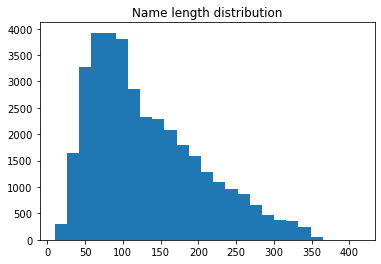

In [2]:
with open("author_quotes.txt") as input_file:
    names = input_file.read()[:-1].split('\n')
    names = [' ' + line for line in names]

names[:15]

plt.title('Name length distribution')
plt.hist(list(map(len, names)), bins=25)



In [3]:
tokens = list(set(''.join(names)))
print(tokens)
num_tokens = len(tokens)
print('num_tokens = ', num_tokens)



['a', 'v', 'W', 'L', 'h', 'X', 'g', '1', '=', '+', 'I', 'Ј', 'p', '*', 'P', '-', 'N', '!', 'b', '9', 'n', 'J', 'z', ',', 'l', 'Ђ', 'j', '6', 'k', '3', 'o', 'D', 'E', ')', 'C', '(', 'Z', 'x', 'y', '8', 'c', 'K', 'T', '2', 'R', 'Q', 'm', 'M', '7', ' ', 'O', 'u', '/', '&', '#', ';', 'B', '"', 'H', '4', '”', '?', 'w', 'S', 'q', 'A', 'd', 'r', "'", 'f', 'F', 's', 'i', 'G', 't', 'Y', 'e', '%', '$', '.', ':', '™', '0', '5', 'в', 'U', 'В', 'V']
num_tokens =  88


In [5]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

token_to_id

assert len(tokens) == len(token_to_id)

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i
print("OK")

def to_matrix(data, token_dict, max_len=None, dtype='int32', batch_first=True):
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_dict[' ']
    
    for i in range(len(data)):
        line_ix = [token_dict[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first:
        data_ix = np.transpose(data_ix)
        
    return data_ix

print('\n'.join(names[::2000]))
print(to_matrix(names[::2000], token_to_id))


OK
 If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.
 In the beginning, everybody that gets to work with me, thinks I'm nice. But three weeks later, they hear a bell ringing. Then they realise I meant everything I said during that first week. It's not my fault people are not taking me serious from the first moment.
 I tend to get comfortable with the dialogue and find out who the person is in the script and try to hit that. People are sort of independent of their occupations and their pastimes. You don't play a politician or a fireman or a cowboy - you just play a person.
 'Tis love that makes the world go round, my baby.
 Some of these kids just don't plain know how good they are: how smart and how much they have to say. You can tell them. You can shine that light on them, one human interaction at a time.
 I was able to realize that I definitely want to make sure that I use my voice, as it gets bigger and bigger, in the wor

In [15]:

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=32, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units #like hidden layers
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
    
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = F.tanh(h_next)
        
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return Variable(torch.zeros(batch_size, self.num_units))
    
    
def rnn_loop(rnn, batch_index):
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size)
    logprobs = []
    
    for x_t in batch_index.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

MAX_LENGTH = max(map(len, names))
print(MAX_LENGTH)

413


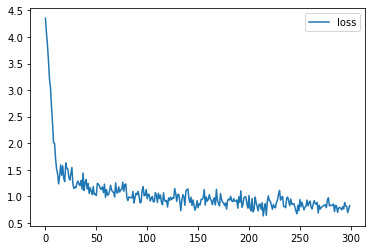

In [16]:

for i in range(300):
    batch_ix = to_matrix(sample(names, 32), token_to_id, max_len = MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype = torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    
    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:, :, None]))
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    
    if(i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didnt converge"




In [17]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=0.5):
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
        
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=1).data.numpy()[0]
        
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])
    

for _ in range(10):
    print(generate_sample(char_rnn))

for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=' Pak'))

 Ive  aler mof to the the ther ant the   ast ous s of and the don eng our ce pond the an is the in ane d ar coc the po the me co the thand at the ing sor ber insthe  an ou and oo  e tin  as the the the and the  uat tourtin the e the tinge ar the the to thang  alonor the dind  isst le d the what  anthave the thates  at oug oole son erers the merhat ans ion wo in  d thang and boris the out  ang bo wo lou therer 
 I                                                                                                                                                                                                                                                                                                                                                                                                                           
 Ise the the me be to  sonore ind ang so the i it    is  ouven sor ane the ant wore oy ou tour thee ss the wor  the  the en lon tou the y arts winthamas lo  an the the dot 